# GPPM for disease progression modeling walktrough

This tutorial introduces the use of the software GPMM available at https://gitlab.inria.fr/epione/GP_progression_model_V2.git.

## Preparation

We start by downloading and installing the package.

In [1]:
!pip install git+https://gitlab.inria.fr/epione/GP_progression_model_V2.git

  Cloning https://gitlab.inria.fr/epione/GP_progression_model_V2.git to /tmp/pip-req-build-t1ve_omt
  Running command git clone -q https://gitlab.inria.fr/epione/GP_progression_model_V2.git /tmp/pip-req-build-t1ve_omt
  Created wheel for gppm: filename=gppm-2.0.0-cp37-none-any.whl size=15757 sha256=d7eb7d0e2574a49813665c3bf04229a2b168fbcdc679b7d790b3d4e44d1f722e
  Stored in directory: /tmp/pip-ephem-wheel-cache-fgskut0k/wheels/dd/c4/65/f8be56a031e989a9c45fbb3e592f8e9612e92ceed37f0e2f9c
Successfully built gppm



Once GPPM is installed, we can import what is needed to run the tutorial

In [2]:
import GP_progression_model

In [3]:
# Setup
import matplotlib.pyplot as plt
import numpy as np
import os
#%matplotlib inline
## workaround for OS X
from sys import platform as sys_pf
if sys_pf == 'darwin':
    matplotlib.use("TkAgg")
import GP_progression_model
from GP_progression_model import DataGenerator
import torch
import pandas as pd
import torch

## Illustration on a synthetic case

To understand the principle behind GPPM, let's generate some data that will be later used to fit the model. 
The aim of GPPM is to reconstruct long-term temporal trajectories from the analysis of collections of short-terms observations. 
To get an idea of the  principle, the following piece of code can be used to generate some synthetic trajectories for *Nbiom* biomarkers, and to sample idnvidual measurements from them. 

In [4]:
os.mkdir('synth')

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.fastest = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Parameters for progression curves and data generation
# Max value of the trajectories 
# (we assume that they range from 0, healthy, to L, pathological)
L = 1
# time interval for the trajectories
interval = [-15,15]

# Number of biomarkers
Nbiom = 4
# Number of individuals
Nsubs = 30
# Gaussian observational noise
noise = 0.1

# We set the seed=111 as a reference for the further analysis
seed = 111
np.random.seed(seed)

# Creating random parameter sets for each biomarker's progression
flag = 0
while (flag!=1):
    CurveParam = []
    for i in range(Nbiom):
        CurveParam.append([L,1*(0.5+np.random.rand()),noise])
        if CurveParam[i][1] > 0.0:
            flag = 1

In [5]:
# Calling the data generator
dg = DataGenerator.DataGenerator(Nbiom, interval, CurveParam, Nsubs, seed)

Here are the generated biomarkers trajectories (continuous lines) that we generated, along with observations from the different subjects (dashed segments). Each subject's observation is assumed to be a noisy realisation from the original trajectory, evaluated over few samples.  The number of time points available per subject is assigned randomly in the DataGenerator routine. 

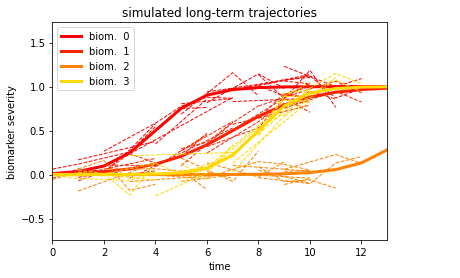

In [6]:
dg.plot('long')

The difference in shape between biomarkers trajectories is due to the different in speed (the slope) and in the timing (the moment at which the trajectory starts increasing). Here is the timing associated with each biomarker: 

In [7]:
# The time_shift indicates the moment at which each biomarker becomes abnormal
ground_truth_ts = dg.time_shift
dict_gt_ts = {}
for biom in range(Nbiom):
  dict_gt_ts['biom_'+ str(biom)] = ground_truth_ts[biom]

pd.DataFrame(dict_gt_ts, index=['change time'])

,biom_0,biom_1,biom_2,biom_3
change time,4.0,7.0,14.0,8.0


We note that the change time associated to biomarker 2 is the furthest in time (at t=14), which means that the trajectory of this biomarker is constant along the entire observation interval.

We are ready not to generate our *real observations*, by resetting the individual observations above to the same origin. In this case, the time information is zero-centered for each subject:

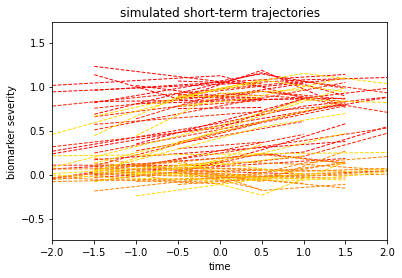

In [8]:
dg.plot('short')

This kind of data is what is generally called *spaghetti plot*. The time axis is not related anymore directly to the original progression, but instead to an arbitrary unit (which may correspond for instance to a visit time). 
**The goal of GPPM is to retrieve the long-term progressions from the spaghetti plot**.

Let's extract our synthetic data as a pandas DataFrame

In [9]:
df  = dg.get_df()

The data frame has the following jey fields:
- RID: the identifier for each individual,  
- time: the zero-centered time (e.g. visit time)
- time_gt: the ground thruth time corresponding to position with respect to the long-term original synthetic trajectories
- biom_*: the measurements for each biomarker and time point

We note that the structure of this data frame is very similar to the one of typical clinical and research datasets (e.g. ADNI). 

In [10]:
df

,RID,time,biom_0,biom_1,biom_2,biom_3,time_gt
0,0.0,-1.5,0.957151,0.570933,0.008824,0.131433,7.0
1,0.0,1.5,1.138082,0.790095,-0.039992,0.836982,10.0
2,1.0,0.0,0.980361,0.653741,0.069481,0.563931,8.0
3,2.0,0.0,0.143012,-0.009545,-0.023385,0.041981,2.0
4,3.0,0.0,1.024214,0.909475,0.036966,0.897041,12.0
...,...,...,...,...,...,...,...
61,28.0,0.0,0.118857,0.111689,-0.118731,-0.059082,3.0
62,29.0,-2.0,0.062574,-0.041898,-0.056814,-0.005067,0.0
63,29.0,-1.0,0.119186,0.064588,0.027764,-0.043569,1.0
64,29.0,1.0,0.256241,0.005242,-0.016863,-0.064809,3.0


### GPPM in action

We are ready to apply GPPM to solve ou estimation problem:

In [11]:
# since the biomarkers are increasing from normal to abnormal states 
# (resp. from 0 to L) we set the monotonicity constraint to 1 for each biomarker
monotonicity = np.repeat(1,Nbiom)

# the input is the generated synthetic data frame
input_data = df.drop(columns=['time_gt'])

# we convert the input data to the pieces that will be fed to GPPM  
Xdata, Ydata, RID, list_biomarkers, group = GP_progression_model.convert_from_df(input_data,
                                                                 ['biom_' + str(i) for i in range(Nbiom)], time_var = 'time')

# here we call GPPM with the appropriate input
model = GP_progression_model.GP_Progression_Model(Xdata,Ydata, monotonicity = monotonicity, trade_off = 50,
                                                  names_biomarkers=['biom_' + str(i) for i in range(Nbiom)] )


Once created our GPPM object, we are ready to optimize. 
The optimization of GPPM iterates over two steps:

- *Estimation of the biomarkers trajectories*. This is a regression problem, and is solved in GPPM by fitting a Gaussian Process (GP) mixed effect model to the observations. Gaussian processes are a fabulous family of non-parametric functions that can be used to solve a large variety of machine learning problems. In the case of GPPM, we impose that the trajectory must be monotonic over time, to describe steady evolutions from normal to pathological states.
- *Estimation of the subject-specific time reparameterization function*. This step idetifies the most likely instant during the pathological evolution at which the individual has been observed, by optimizing the timing of the measurements with respect to the trajectories estimated above. The current version of the model support the estimation of both time-shift and scaling parameters.

Let's run the optimization and observe how trajectories and individual parameters evolve over the iterations.

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Optimization step: 1 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 13.25 - Cost (fit): 561.91 - Cost (constr): 397.93|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 50 of 200 || Cost (DKL): 11.88 - Cost (fit): 247.36 - Cost (constr): 147.48|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 100 of 200 || Cost (DKL): 12.97 - Cost (fit): 231.56 - Cost (constr): 73.85|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 150 of 200 || Cost (DKL): 13.36 - Cost (fit): 191.68 - Cost (constr): 35.62|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 200 of 200 || Cost (DKL): 12.24 - Cost (fit): 212.93 - Cost (constr): 16.93|| Batch (each iter) of size 30 || Time (each iter): 0.03s


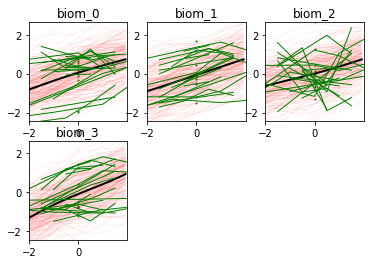

 -- Time reparameterization --
Iteration 1 of 200 || Cost (DKL): 12.24 - Cost (fit): 196.29 - Cost (constr): 18.12|| Batch (each iter) of size 30 || Time (each iter): 0.04s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 12.24 - Cost (fit): 257.13 - Cost (constr): 16.38|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 100 of 200 || Cost (DKL): 12.24 - Cost (fit): 195.80 - Cost (constr): 20.30|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 150 of 200 || Cost (DKL): 12.24 - Cost (fit): 175.13 - Cost (constr): 21.53|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 200 of 200 || Cost (DKL): 12.24 - Cost (fit): 178.07 - Cost (constr): 21.71|| Batch (each iter) of size 30 || Time (each iter): 0.03s


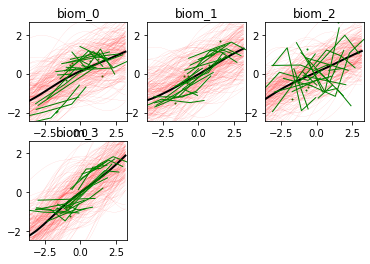

Optimization step: 2 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 12.23 - Cost (fit): 183.16 - Cost (constr): 65.77|| Batch (each iter) of size 30 || Time (each iter): 0.05s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 12.46 - Cost (fit): 135.83 - Cost (constr): 32.55|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 100 of 200 || Cost (DKL): 13.19 - Cost (fit): 136.28 - Cost (constr): 27.13|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 13.67 - Cost (fit): 96.70 - Cost (constr): 19.02|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 200 of 200 || Cost (DKL): 14.19 - Cost (fit): 109.62 - Cost (constr): 16.38|| Batch (each iter) of size 30 || Time (each iter): 0.04s


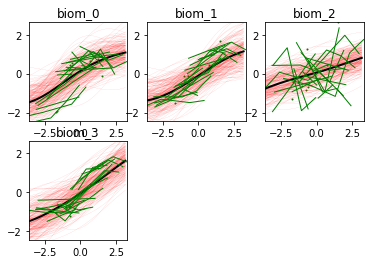

 -- Time reparameterization --
Iteration 1 of 200 || Cost (DKL): 14.19 - Cost (fit): 86.57 - Cost (constr): 16.38|| Batch (each iter) of size 30 || Time (each iter): 0.04s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 14.19 - Cost (fit): 79.00 - Cost (constr): 25.71|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 100 of 200 || Cost (DKL): 14.19 - Cost (fit): 54.81 - Cost (constr): 16.38|| Batch (each iter) of size 30 || Time (each iter): 0.05s
Iteration 150 of 200 || Cost (DKL): 14.19 - Cost (fit): 87.39 - Cost (constr): 16.39|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 200 of 200 || Cost (DKL): 14.19 - Cost (fit): 66.38 - Cost (constr): 27.32|| Batch (each iter) of size 30 || Time (each iter): 0.03s


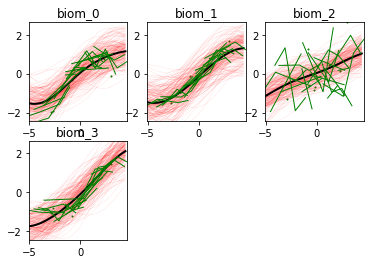

Optimization step: 3 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 14.20 - Cost (fit): 47.10 - Cost (constr): 16.39|| Batch (each iter) of size 30 || Time (each iter): 0.05s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 14.96 - Cost (fit): 66.14 - Cost (constr): 16.38|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 100 of 200 || Cost (DKL): 15.68 - Cost (fit): 55.46 - Cost (constr): 17.07|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 18.36 - Cost (fit): 39.08 - Cost (constr): 22.58|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 200 of 200 || Cost (DKL): 20.71 - Cost (fit): 21.32 - Cost (constr): 16.42|| Batch (each iter) of size 30 || Time (each iter): 0.03s


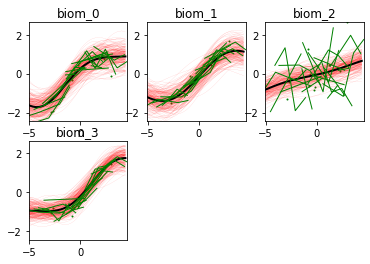

 -- Time reparameterization --
Iteration 1 of 200 || Cost (DKL): 20.71 - Cost (fit): 13.54 - Cost (constr): 19.10|| Batch (each iter) of size 30 || Time (each iter): 0.04s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 20.71 - Cost (fit): 18.04 - Cost (constr): 23.65|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 100 of 200 || Cost (DKL): 20.71 - Cost (fit): -20.37 - Cost (constr): 16.73|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 20.71 - Cost (fit): -4.59 - Cost (constr): 23.27|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 200 of 200 || Cost (DKL): 20.71 - Cost (fit): -45.78 - Cost (constr): 16.77|| Batch (each iter) of size 30 || Time (each iter): 0.03s


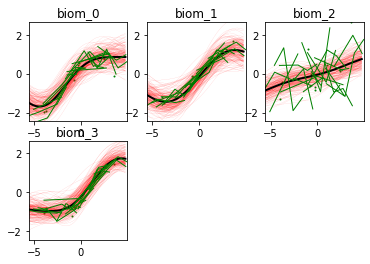

Optimization step: 4 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 20.77 - Cost (fit): -25.26 - Cost (constr): 44.43|| Batch (each iter) of size 30 || Time (each iter): 0.05s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 21.38 - Cost (fit): 4.16 - Cost (constr): 24.58|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 100 of 200 || Cost (DKL): 23.20 - Cost (fit): -49.49 - Cost (constr): 16.41|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 27.05 - Cost (fit): -24.88 - Cost (constr): 16.46|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 200 of 200 || Cost (DKL): 27.96 - Cost (fit): -94.43 - Cost (constr): 16.70|| Batch (each iter) of size 30 || Time (each iter): 0.04s


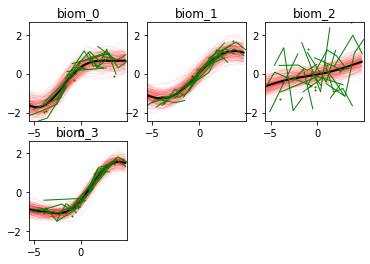

 -- Time reparameterization --
Iteration 1 of 200 || Cost (DKL): 27.96 - Cost (fit): -63.17 - Cost (constr): 16.69|| Batch (each iter) of size 30 || Time (each iter): 0.04s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 27.96 - Cost (fit): -37.79 - Cost (constr): 34.51|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 100 of 200 || Cost (DKL): 27.96 - Cost (fit): -41.31 - Cost (constr): 17.95|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 27.96 - Cost (fit): -69.53 - Cost (constr): 18.36|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 200 of 200 || Cost (DKL): 27.96 - Cost (fit): -50.48 - Cost (constr): 16.78|| Batch (each iter) of size 30 || Time (each iter): 0.03s


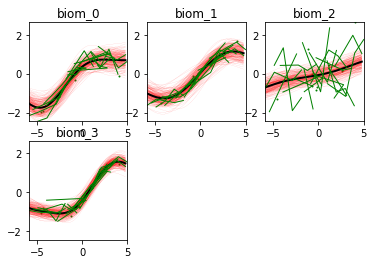

Optimization step: 5 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 27.90 - Cost (fit): -62.58 - Cost (constr): 25.23|| Batch (each iter) of size 30 || Time (each iter): 0.05s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 31.22 - Cost (fit): -93.57 - Cost (constr): 24.56|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 100 of 200 || Cost (DKL): 31.17 - Cost (fit): -55.88 - Cost (constr): 16.78|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 32.82 - Cost (fit): -39.18 - Cost (constr): 26.82|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 200 of 200 || Cost (DKL): 34.94 - Cost (fit): -81.30 - Cost (constr): 16.47|| Batch (each iter) of size 30 || Time (each iter): 0.03s


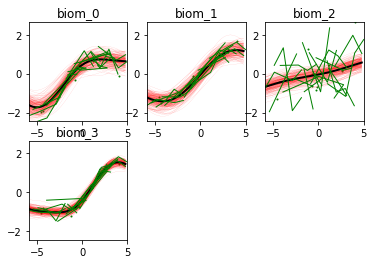

 -- Time reparameterization --
Iteration 1 of 200 || Cost (DKL): 34.94 - Cost (fit): -105.57 - Cost (constr): 17.96|| Batch (each iter) of size 30 || Time (each iter): 0.05s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 34.94 - Cost (fit): -82.13 - Cost (constr): 25.58|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 100 of 200 || Cost (DKL): 34.94 - Cost (fit): -113.09 - Cost (constr): 18.01|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 34.94 - Cost (fit): -73.93 - Cost (constr): 30.28|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 200 of 200 || Cost (DKL): 34.94 - Cost (fit): -69.13 - Cost (constr): 16.62|| Batch (each iter) of size 30 || Time (each iter): 0.03s


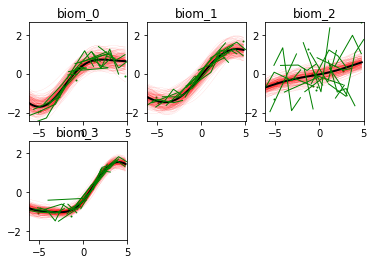

Optimization step: 6 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 34.98 - Cost (fit): -104.41 - Cost (constr): 16.41|| Batch (each iter) of size 30 || Time (each iter): 0.05s


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Iteration 50 of 200 || Cost (DKL): 36.84 - Cost (fit): -35.97 - Cost (constr): 16.89|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 100 of 200 || Cost (DKL): 37.21 - Cost (fit): -97.80 - Cost (constr): 16.47|| Batch (each iter) of size 30 || Time (each iter): 0.03s
Iteration 150 of 200 || Cost (DKL): 37.96 - Cost (fit): -96.83 - Cost (constr): 21.81|| Batch (each iter) of size 30 || Time (each iter): 0.04s
Iteration 200 of 200 || Cost (DKL): 38.19 - Cost (fit): -78.80 - Cost (constr): 23.04|| Batch (each iter) of size 30 || Time (each iter): 0.03s


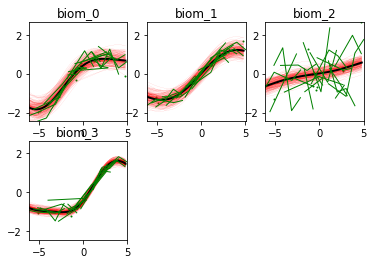

In [12]:
model.Optimize(plot = True, verbose = True, benchmark=True)

Here we go! 
The estimated trajectories can be observed with the command *model.Plot()*

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


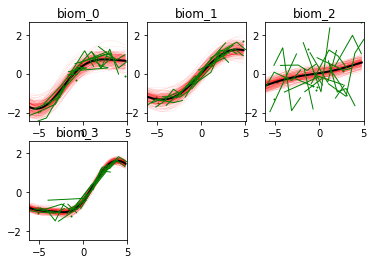

In [13]:
model.Plot()

GPPM an produce a variety of figures that can be used to interpret the results and extract a lot of useful information about data and trajectories

In [14]:
#This command saves the fitted biomarkers trajectories in separate files
model.Plot(save_fig = './synth/')


/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Let's read the images one by one

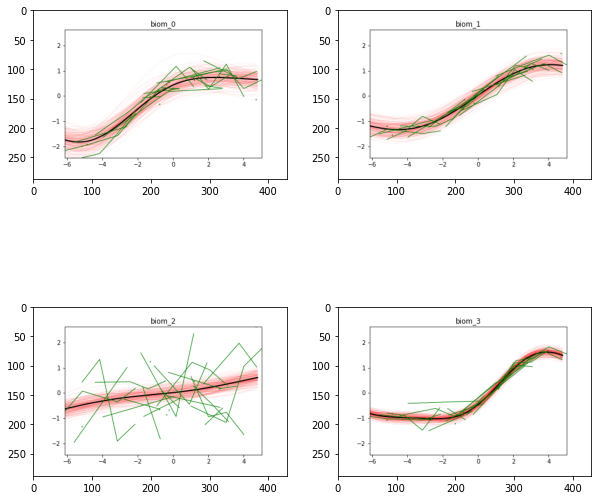

In [15]:
plt.figure(figsize=(10,10))
for i in range(Nbiom):
  plt.subplot(2,2,i+1)
  fig_biom = plt.imread('./synth/biom_'+str(i)+'.png')
  plt.imshow(fig_biom)

We note that the estimated uncertainty for biomarker 2 is large, and that the trajectory is mostly flat.

By plotting with the option *join=True* we can extract more information on the fitted trajectories:

In [16]:
# with the option 
model.Plot(save_fig = './synth/', joint = True)

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


A key information for understanding the relationship between biomarkers is the estimated time of maximum change. This is the moment at which the speed of the estimated trajectory is maximum, and indicates the relative positioning (ranking) of the biomarkers when varying from normal to pathological stages.

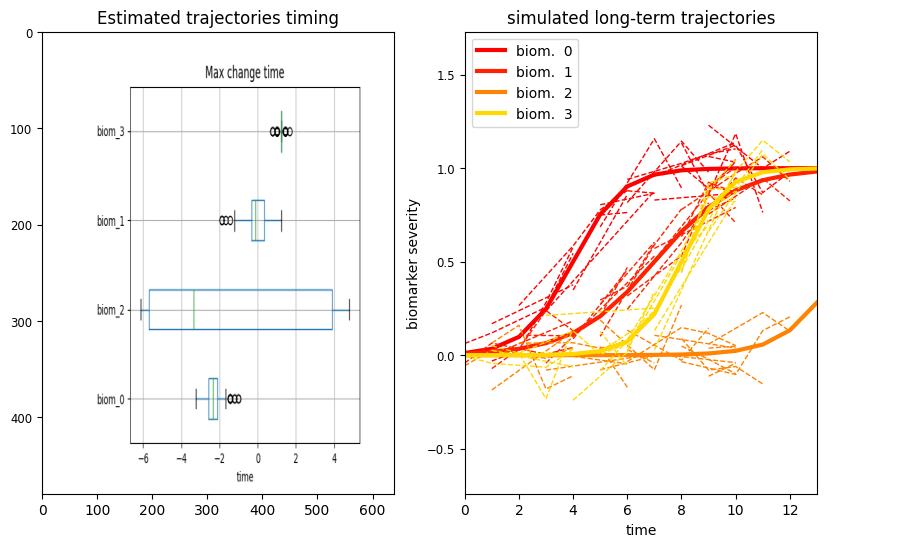

In [17]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
timing = plt.imread('./synth/change_timing.png')
plt.imshow(timing, aspect='auto')
plt.title('Estimated trajectories timing')
plt.subplot(1,2,2)
dg.plot('long')

We observe that the order of the four biomarkers across the estimated time-axis correponds to the ground thruth change time generated for the synthetic data. The most interesting observation is that biomarker 2 is associated with very large uncertainty, since it is flat. In this case there is not a well defined transition time, and this leads to high uncertainty of the model: based on the data, it is not possible to establish when this biomarker is going to transition from normal to pathological values.

We can also quantify the magnitude of the trajectories of changes of each biomarker:

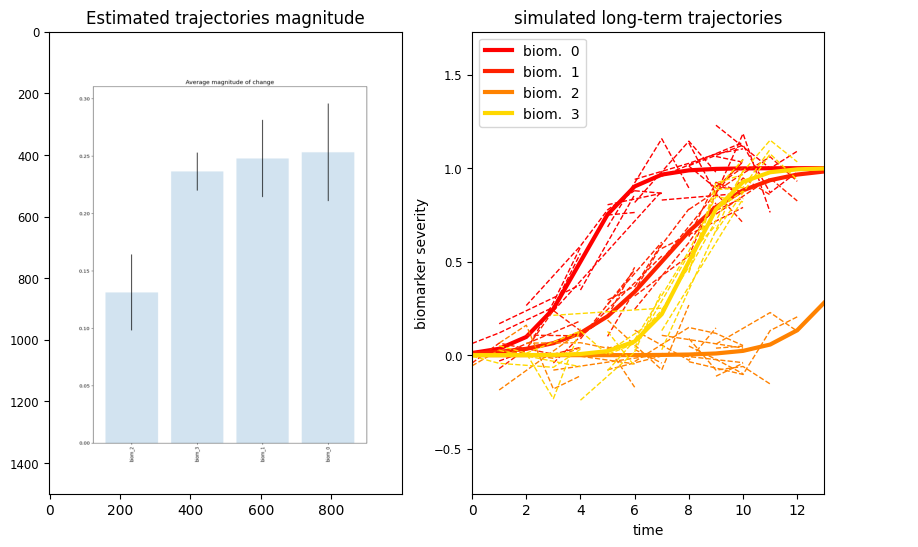

In [18]:
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
magnitude = plt.imread('./synth/change_magnitude.png')
plt.imshow(magnitude, aspect = 'auto')
plt.title('Estimated trajectories magnitude')
plt.subplot(1,2,2)
dg.plot('long')


We can see that biomarker 2 is associated with the lowest amount of change across the estimated long-term progression. Biomarker 0 and 3 are the one changing the most, and this is in agreement with the synthetic trajectories originally generated.

Given the model, it is possible to estimate the time-shift (or disease severity) associated with each individual, based on the available set of biomarkers. This can be simply done with the following command:

In [19]:
pred_time_shift = model.PredictOptimumTime(input_data, id_var='RID', time_var='time')

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [20]:
pred_time_shift

,time,Time Shift
RID,,
0.0,-1.5,1.301284
1.0,0.0,1.301284
2.0,0.0,-5.384358
3.0,0.0,2.415557
4.0,-1.0,-1.670112
5.0,0.0,-0.184415
6.0,0.0,-0.184415
7.0,-1.5,0.558435
8.0,-1.5,-0.184415


We can plot the predicted individual time-shift against the ground truth time-shift generated for each individual.

Text(0, 0.5, 'ground truth disease stage')

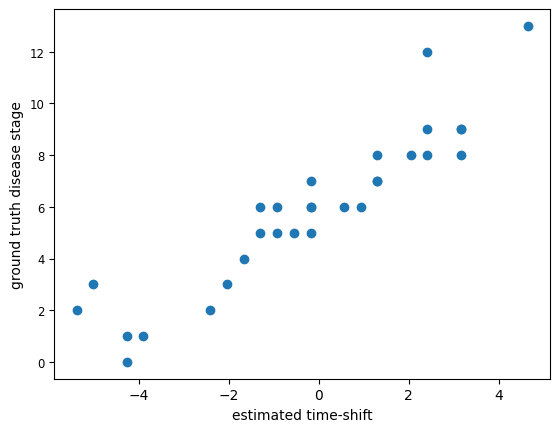

In [21]:
ground_truth = dg.OutputTimeShift()

plt.scatter(pred_time_shift['Time Shift'],ground_truth) 
plt.xlabel('estimated time-shift')
plt.ylabel('ground truth disease stage')

The estimated time-shift is in lage agreement with the original positioning of each individual in the time-axis of the long-term trajectories.

## Modeling of longitudinal biomarkers from the (pseudo-)ADNI dataset

This last section illustrates the use of GPPM on real data.
We are going to work with a pseudo-version of ADNI. The dataset consists of biomarkers collected over time for 171 subjects. 82 individuals are healhty (NL), 752 are affected by mild cognitive impairment (MCI), and 82 are patients with Alzheimer's disease (AD). 
The measurements were created based on the biomarker's measures observed in the original ADNI dataset.

---



In [22]:
os.mkdir('real')

pseudo_adni = pd.read_csv('http://marcolorenzi.github.io/material/pseudo_adni.csv')

print(pseudo_adni.columns)

diags = { 'NL' : np.sum(pseudo_adni['group']==1), 
          'MCI' : np.sum(pseudo_adni['group']==2), 
          'AD' : np.sum(pseudo_adni['group']==3), }
diags

Index(['RID', 'Time', 'Hippocampus', 'Ventricles', 'Entorhinal', 'WholeBrain',
       'ADAS11', 'FAQ', 'AV45', 'FDG', 'group'],
      dtype='object')


{'AD': 320, 'MCI': 752, 'NL': 82}

### GPPM in action

As for the synthetic example, we first convert the original data frame into a GPPM input

In [23]:
biomarkers = ['Hippocampus', 'Ventricles', 'Entorhinal', 'WholeBrain',
       'ADAS11', 'FAQ', 'AV45', 'FDG']
Xdata, Ydata, RID, list_biomarkers, group = GP_progression_model.convert_from_df(pseudo_adni,
                                                                 biomarkers, time_var = 'Time')


In this case we need to specify a meaningful monotonicity constraint for each biomarkers. The monotonicity will reflect our knowledge on how each biomarker varies from normal to pathological values. 
For example, the brain volume decreases over time, and therefore the monotonicity constraint will be negative. On the contrary, the clinical score ADAS11 increases with more advanced pathological states, and therefore the monotonicity constraint will be positive. 

We obtain:

In [24]:
dict_monotonicity = { 'Hippocampus' : -1, #decreasing
                     'Ventricles': 1, #increasing
                     'Entorhinal': -1, #decreasing
                     'WholeBrain': -1, #decreasing
                     'ADAS11': 1, #increasing
                     'FAQ': 1, #increasing
                     'AV45': 1, #increasing
                     'FDG': -1, #decreasing
                    }

We are ready to run and optimize GPPM on this dataset:

In [25]:
# trade off between data-fit and monotonicity
trade_off = 100

# create a GPPM object
model = GP_progression_model.GP_Progression_Model(Xdata,Ydata, names_biomarkers = biomarkers, monotonicity = [dict_monotonicity[k] for k in dict_monotonicity.keys()], trade_off = trade_off,
                                                  groups = group, group_names = ['NL','MCI','AD'], device = device)
model.model = model.model.to(device)

# Optimise the model
N_outer_iterations = 6
N_iterations = 200
model.Optimize(N_outer_iterations = N_outer_iterations, N_iterations = N_iterations, n_minibatch = 10, verbose = True, plot = False, benchmark = True)

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


Optimization step: 1 out of 6
 -- Regression --
Iteration 1 of 200 || Cost (DKL): 14.97 - Cost (fit): 212.72 - Cost (constr): 1686.99|| Batch (each iter) of size 9 || Time (each iter): 0.07s
Iteration 50 of 200 || Cost (DKL): 14.50 - Cost (fit): 343.64 - Cost (constr): 760.40|| Batch (each iter) of size 9 || Time (each iter): 0.10s
Iteration 100 of 200 || Cost (DKL): 18.20 - Cost (fit): 207.07 - Cost (constr): 446.34|| Batch (each iter) of size 9 || Time (each iter): 0.08s
Iteration 150 of 200 || Cost (DKL): 22.10 - Cost (fit): 226.81 - Cost (constr): 275.52|| Batch (each iter) of size 9 || Time (each iter): 0.09s
Iteration 200 of 200 || Cost (DKL): 24.29 - Cost (fit): 242.91 - Cost (constr): 204.69|| Batch (each iter) of size 9 || Time (each iter): 0.08s
 -- Time reparameterization --
Iteration 1 of 200 || Cost (DKL): 24.29 - Cost (fit): 180.17 - Cost (constr): 106.46|| Batch (each iter) of size 9 || Time (each iter): 0.07s
Iteration 50 of 200 || Cost (DKL): 24.29 - Cost (fit): 172.65

And here is the output of our model: the biomarkers show different progression shapes, and different variability of the individual measurements.

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


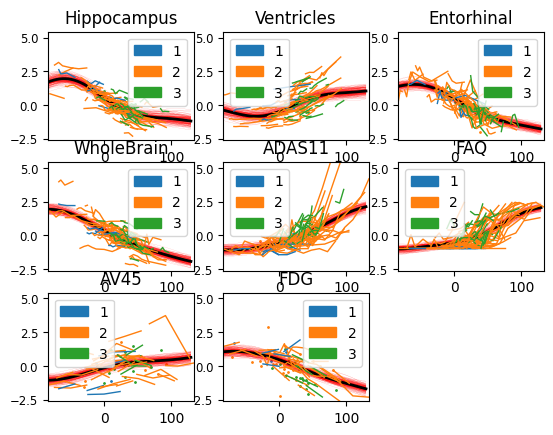

In [26]:
model.Plot()

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Estimated trajectories timing')

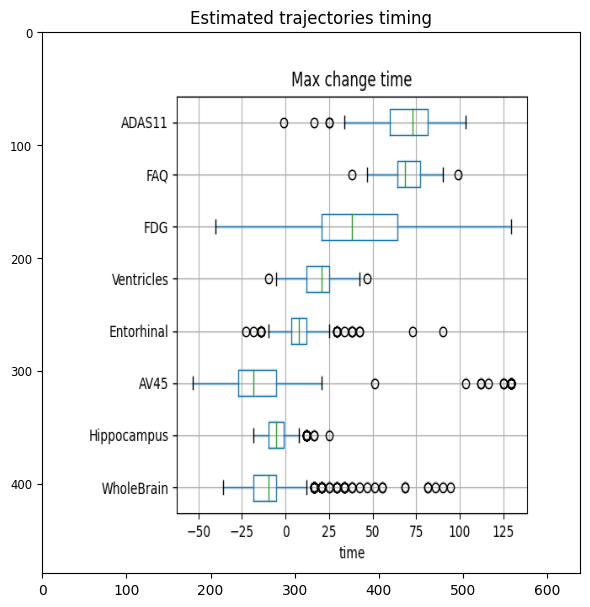

In [27]:
model.Plot(save_fig = './real/')
model.Plot(save_fig = './real/', joint = True)

plt.figure(figsize=(6,6))
timing = plt.imread('./real/change_timing.png')
plt.imshow(timing, aspect='auto')
plt.tight_layout()
plt.title('Estimated trajectories timing')

The orderning of the biomarkers reflects the progression curves estimated above. The biomarkers showing the earliest changes are Hippocampus, whole brain and AV45, although the timing of this latter biomarker is more uncertain. The abnormality of entorhinal cortex and ventricles appears later. The changes of glucose metabolism are more spread towards the latest stages of the disease, while the clinical scores FAQ and ADAS11 are the last to reach abnormal values. This figure is quite in agreement with the known biomarker progression reported for Alzheimer's disease.

Text(0.5, 1.0, 'Estimated trajectories magnitude')

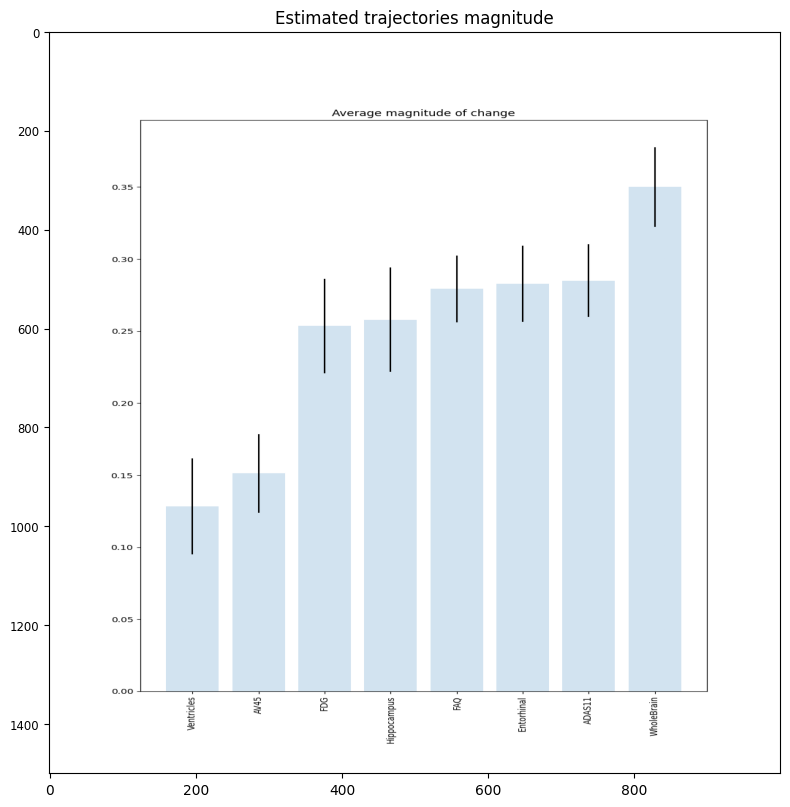

In [28]:
plt.figure(figsize=(8,8))
timing = plt.imread('./real/change_magnitude.png')
plt.imshow(timing, aspect='auto')
plt.tight_layout()
plt.title('Estimated trajectories magnitude')

We can finally predict the disease severity associated with each individual, and compare these estimates group-wise.

In [29]:
pred_time_shift = model.PredictOptimumTime(pseudo_adni, id_var='RID', time_var='Time')

/usr/local/lib/python3.7/dist-packages/torch/tensor.py:474: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [30]:
# This command creates another .csv file
pred_time_shift.to_csv('./real/predictions.csv')

diag_dict = dict([(1,'NL'),(2,'MCI'),(3,'AD')])
pred_time_shift.reset_index(inplace=True)

In [31]:
pred_time_shift

,RID,Time,Time Shift
0,0,0,54.077762
1,1,0,10.560256
2,2,0,17.813173
3,3,0,83.089431
4,4,0,126.606940
...,...,...,...
166,166,0,68.583595
167,167,0,-61.968920
168,168,0,54.077762
169,169,0,54.077762


In [32]:
rid_group = pseudo_adni.loc[~pseudo_adni['RID'].duplicated(),][['RID','group']]
group_and_ts = rid_group.merge(pred_time_shift, on = 'RID')

In [33]:
group_and_ts = rid_group.merge(pred_time_shift, on = 'RID')

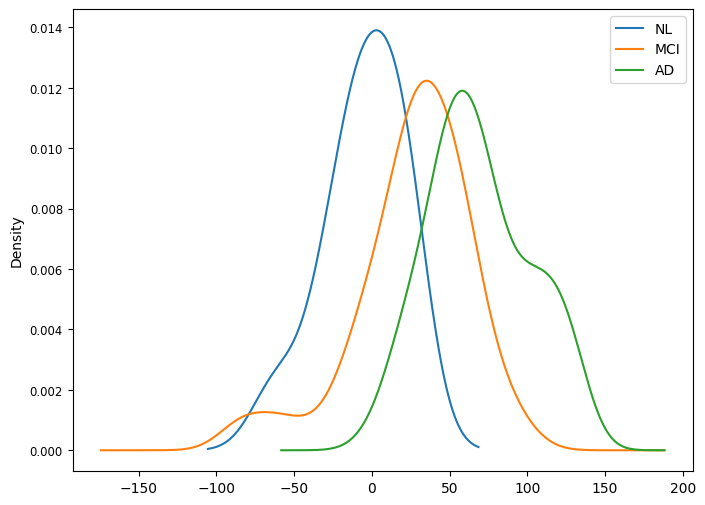

In [34]:
fig, ax = plt.subplots(figsize=(8,6))
for label, df in group_and_ts.groupby('group'):
    if len(df['Time Shift'])>1:
        df['Time Shift'].plot(kind="kde", ax=ax, label= diag_dict[label])
    else:
        print('Warning: ' + label + ' group has only 1 element and will not be displayed')
plt.legend()

Patients with AD appear significantly more advanced on the disease time-axis as compared to MCI and healthy, while MCI subjects are in between healthy and AD groups. 